### Example 4: Burgers' equation

Now that we have seen how to construct the non-linear convection and diffusion examples, we can combine them to form Burgers' equations. We again create a set of coupled equations which are actually starting to form quite complicated stencil expressions, even if we are only using low-order discretizations.

Let's start with the definition fo the governing equations:
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \; \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}\right)$$
 
$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \; \left(\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}\right)$$

The discretized and rearranged form then looks like this:

\begin{aligned}
u_{i,j}^{n+1} &= u_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (u_{i,j}^n - u_{i-1,j}^n) - \frac{\Delta t}{\Delta y} v_{i,j}^n (u_{i,j}^n - u_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n-2u_{i,j}^n+u_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
\end{aligned}

\begin{aligned}
v_{i,j}^{n+1} &=  v_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (v_{i,j}^n - v_{i-1,j}^n) - \frac{\Delta t}{\Delta y} v_{i,j}^n (v_{i,j}^n - v_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j+1}^n)
\end{aligned}

Great. Now before we look at the Devito implementation, let's re-create the NumPy-based implementation from the original.

In [3]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 41  # Grid size on x axis
ny = 41  # Grid size on y axis

batches = 5 # Batches of timesteps, increase number of batches to extend evolution in time
# A figure of the wave state will be produced for each batch.
# Increase number of batches to extend evolution in time
batch_size = 640 # Number of timesteps for every batch
nt = batches*batch_size # Number of total timesteps

c = 1
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu

batches = 5 # Batches of timesteps
# Total number of timesteps is `batches*nt`
# A figure of the wave state will be produced for each batch.
# Increase number of batches to extend evolution in time

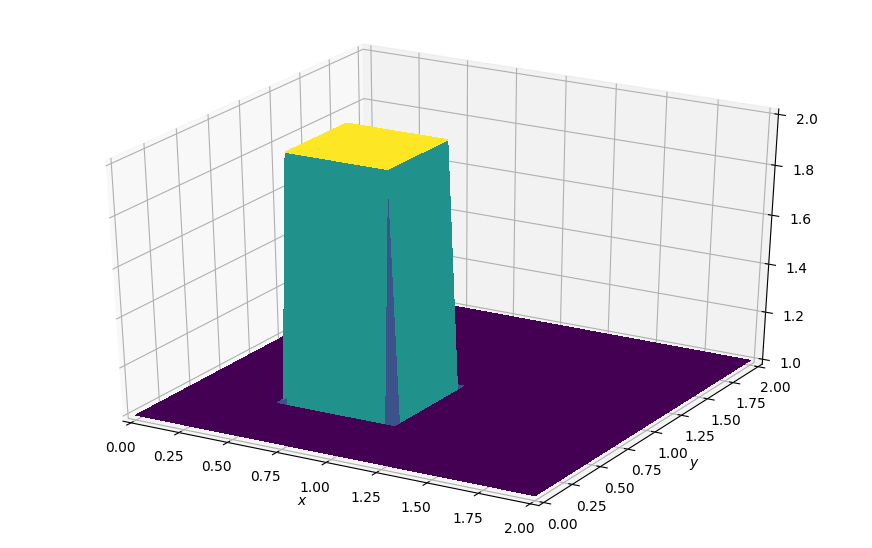

In [4]:
#NBVAL_IGNORE_OUTPUT

# Assign initial conditions
u = np.empty((nx, ny))
v = np.empty((nx, ny))

init_hat(field=u, dx=dx, dy=dy, value=2.)
init_hat(field=v, dx=dx, dy=dy, value=2.)

plot_field(u)

Batch: 0.0


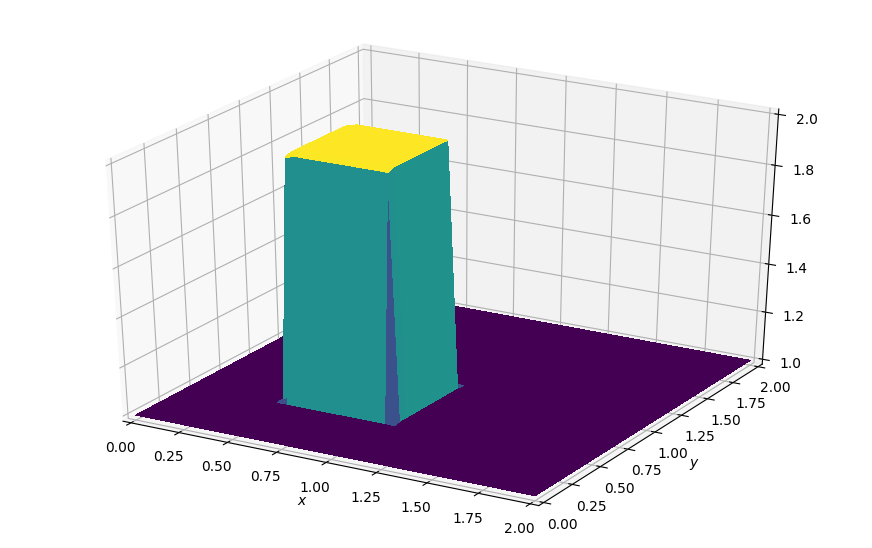

Batch: 1.0


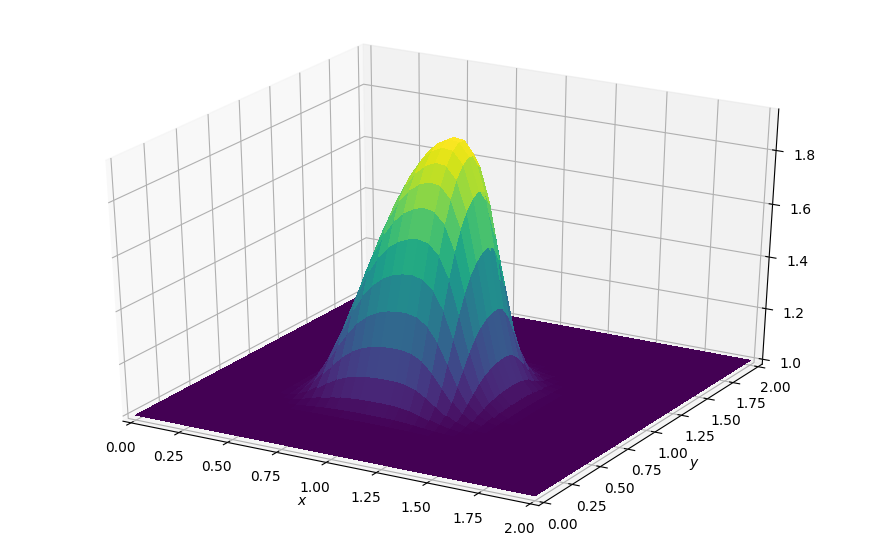

Batch: 2.0


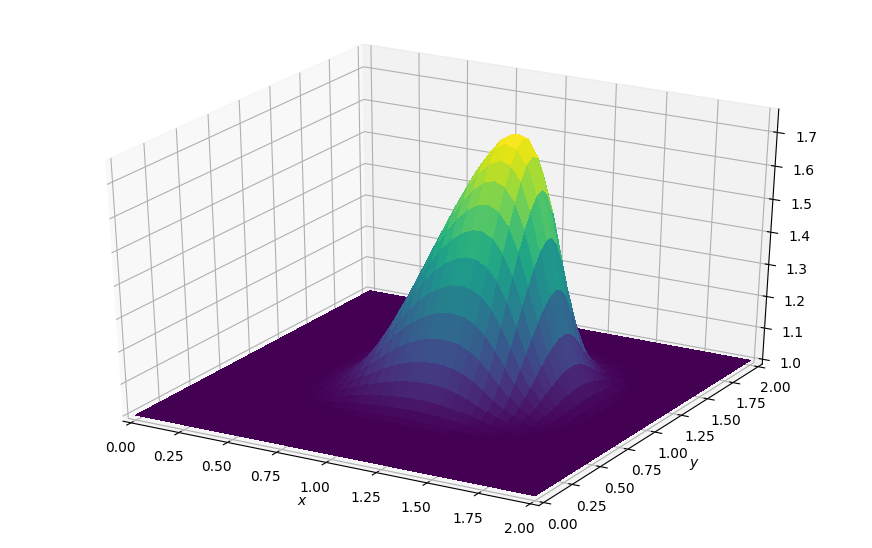

Batch: 3.0


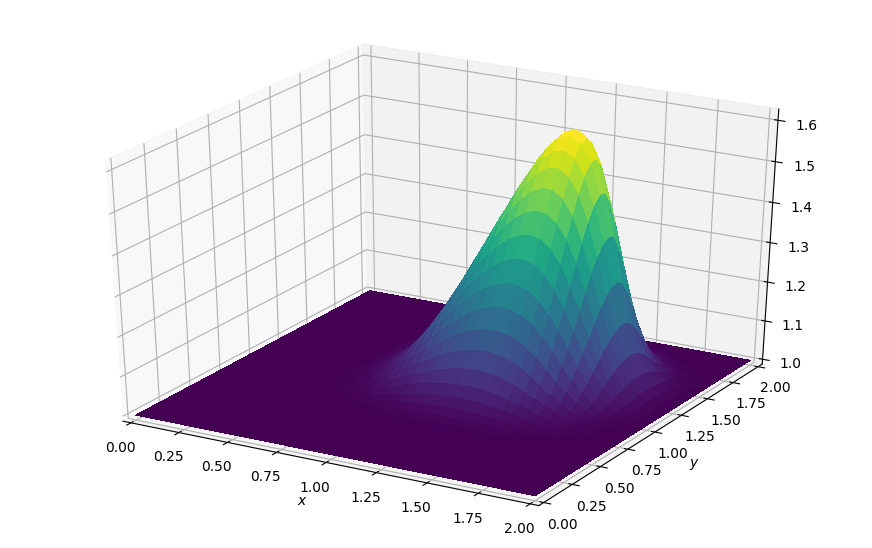

Batch: 4.0


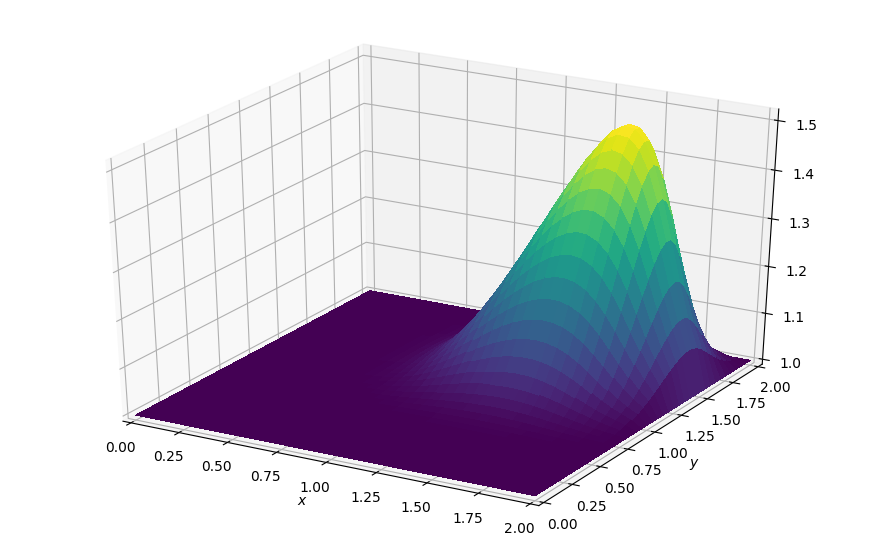

Batch: 5.0


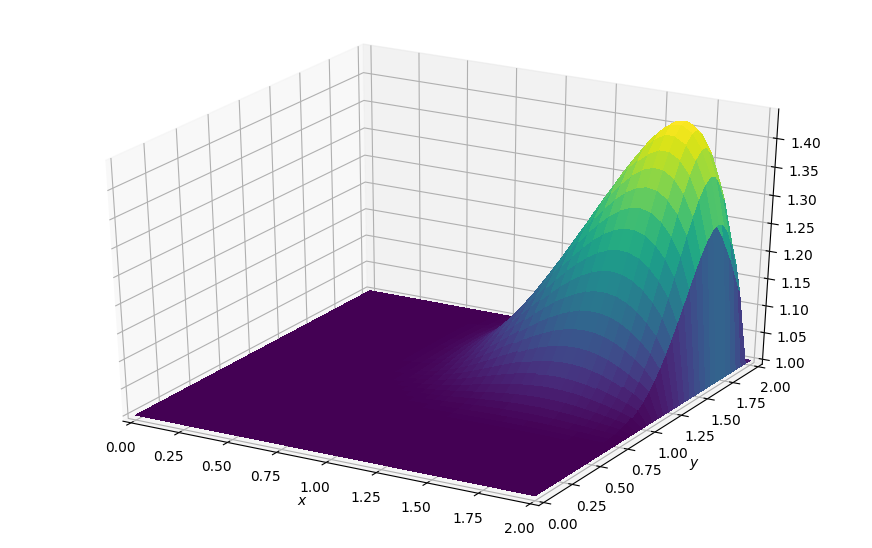

In [5]:
#NBVAL_IGNORE_OUTPUT

for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
    
    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - 
                     dt / dx * un[1:-1, 1:-1] *
                     (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     dt / dy * vn[1:-1, 1:-1] * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     nu * dt / dy**2 *
                     (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1]))
     
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    
    
    # A figure of the wave state will be produced for each batch
    if (n%batch_size) == 0:
        print ("Batch:",n/(batch_size))
        plot_field(u)

Nice, our wave looks just like the original. Now we shall attempt to write our entire Burgers' equation operator in a single cell - but before we can demonstrate this, there is one slight problem.

The diffusion term in our equation requires a second-order space discretization on our velocity fields, which we set through the `TimeFunction` constructor for $u$ and $v$. The `TimeFunction` objects will store this dicretisation information and use it as default whenever we use the shorthand notations for derivative, like `u.dxl` or `u.dyl`. For the advection term, however, we want to use a first-order discretization, which we now have to create by hand when combining terms with different stencil discretizations. To illustrate let's consider the following example: 

In [7]:
from devito import Grid, TimeFunction, first_derivative, left

grid = Grid(shape=(nx, ny), extent=(2., 2.))
x, y = grid.dimensions
t = grid.stepping_dim

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
#dt = model.critical_dt  # Time step from model grid spacing

steps = int((t0+tn)/dt)+2


u1 = TimeFunction(name='u1', grid=grid, space_order=1, save=steps)
print("Space order 1:\n%s\n" % u1.dxl)

u2 = TimeFunction(name='u2', grid=grid, space_order=2, save=steps)
print("Space order 2:\n%s\n" % u2.dxl)

# We use u2 to create the explicit first-order derivative
u1_dx = first_derivative(u2, dim=x, side=left, fd_order=1)
print("Explicit space order 1:\n%s\n" % u1_dx)

Trying to allocate more memory for symbol u1 than available on physical device, this will start swapping
Trying to allocate more memory for symbol u2 than available on physical device, this will start swapping


Space order 1:
Derivative(u1(time, x, y), x)

Space order 2:
Derivative(u2(time, x, y), x)

Explicit space order 1:
u2(time, x, y)/h_x - u2(time, x - h_x, y)/h_x



Ok, so by constructing derivative terms explicitly we again have full control of the spatial discretization - the power of symbolic computation. Armed with that trick, we can now build and execute our advection-diffusion operator from scratch in one cell.

Operator `Kernel` run in 0.05 s


Batch: 1


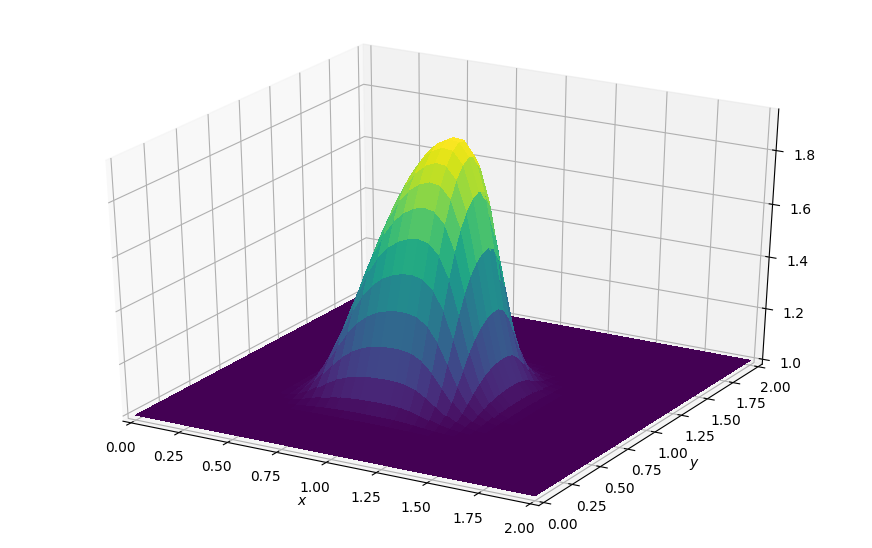

Operator `Kernel` run in 0.07 s


Batch: 2


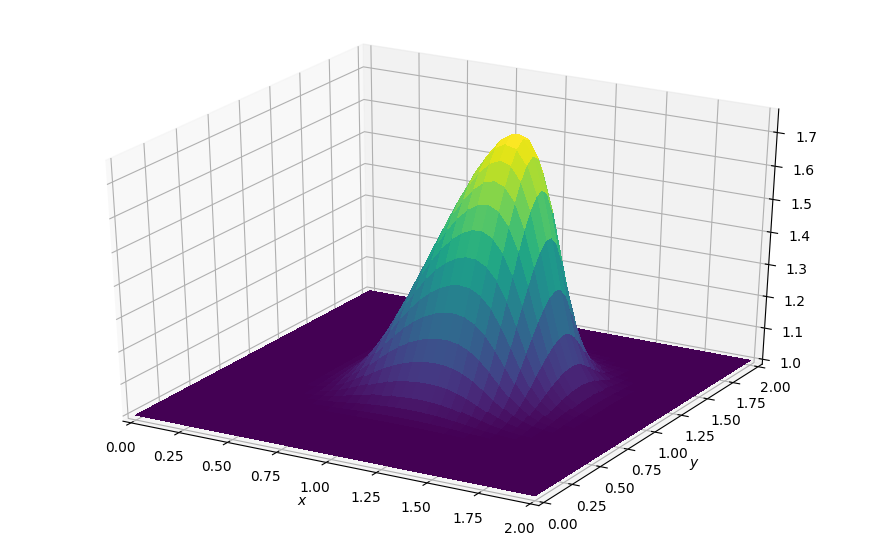

Operator `Kernel` run in 0.05 s


Batch: 3


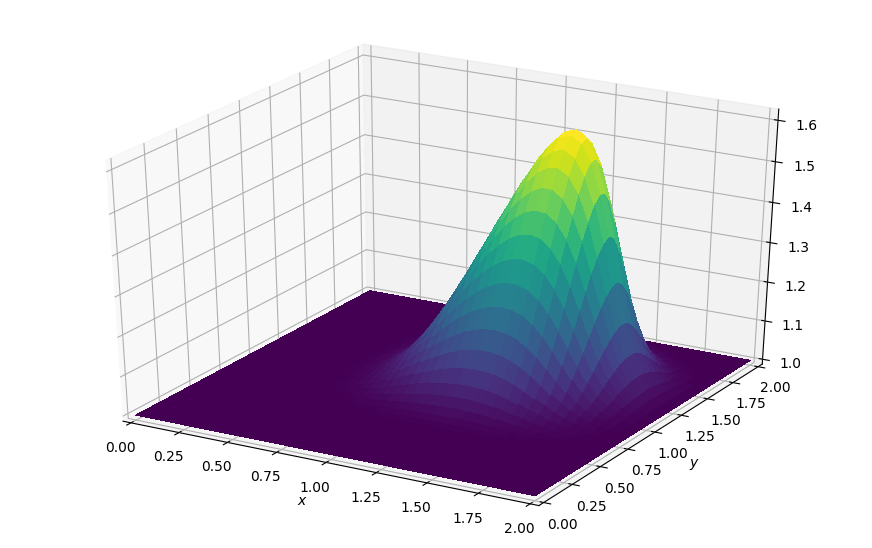

Operator `Kernel` run in 0.23 s


Batch: 4


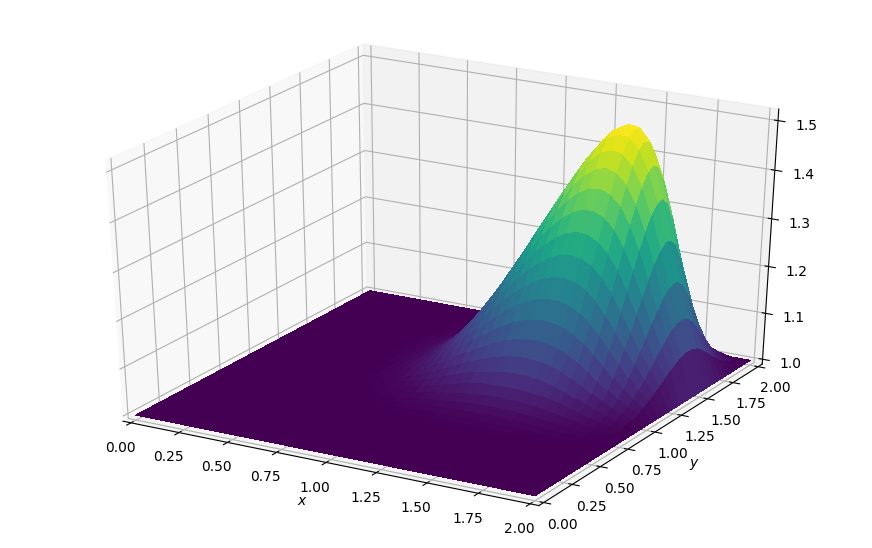

Operator `Kernel` run in 0.06 s


Batch: 5


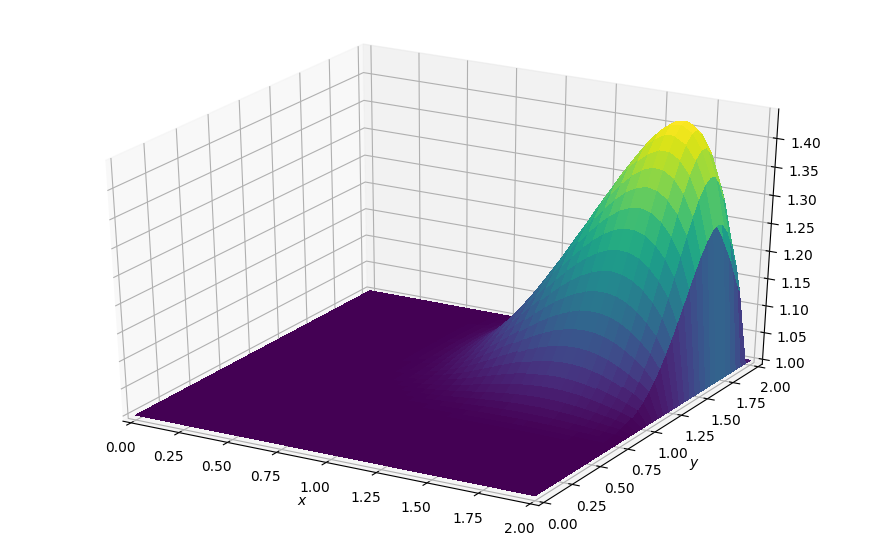

In [5]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator, Constant, Eq, solve

# Define our velocity fields and initialize with hat function
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2)
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

# Write down the equations with explicit backward differences
a = Constant(name='a')
u_dx = first_derivative(u, dim=x, side=left, fd_order=1)
u_dy = first_derivative(u, dim=y, side=left, fd_order=1)
v_dx = first_derivative(v, dim=x, side=left, fd_order=1)
v_dy = first_derivative(v, dim=y, side=left, fd_order=1)
eq_u = Eq(u.dt + u*u_dx + v*u_dy, a*u.laplace, subdomain=grid.interior)
eq_v = Eq(v.dt + u*v_dx + v*v_dy, a*v.laplace, subdomain=grid.interior)

# Let SymPy rearrange our stencils to form the update expressions
stencil_u = solve(eq_u, u.forward)
stencil_v = solve(eq_v, v.forward)
update_u = Eq(u.forward, stencil_u)
update_v = Eq(v.forward, stencil_v)

# Create Dirichlet BC expressions using the low-level API
bc_u = [Eq(u[t+1, 0, y], 1.)]  # left
bc_u += [Eq(u[t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(u[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u[t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(v[t+1, 0, y], 1.)]  # left
bc_v += [Eq(v[t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(v[t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(v[t+1, x, 0], 1.)]  # bottom

# Create the operator
op = Operator([update_u, update_v] + bc_u + bc_v)

# Execute the operator for a number of timesteps
for batch_no in range(batches):
    op(time=batch_size, dt=dt, a=nu)
    print ("Batch:",batch_no+1)
    plot_field(u.data[0])


Following the non-linear convection example, we now rewrtie this example in term of vectorial equation

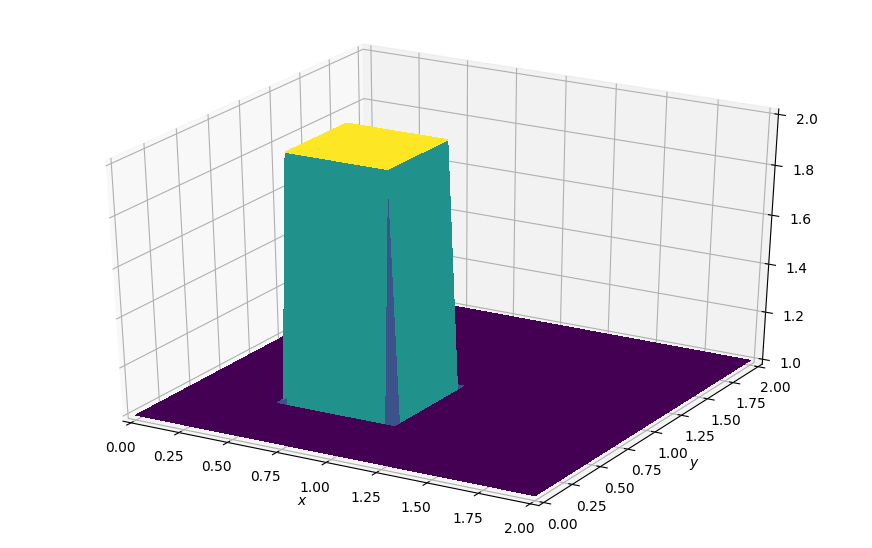

In [6]:
from devito import VectorTimeFunction, grad, div, NODE
x, y = grid.dimensions

U = VectorTimeFunction(name='U', grid=grid, space_order=2)
init_hat(field=U[0].data[0], dx=dx, dy=dy, value=2.)
init_hat(field=U[1].data[0], dx=dx, dy=dy, value=2.)

plot_field(U[1].data[0])

eq_u = Eq(U.dt + grad(U)*U - a * div(grad(U)))

Boundary conditions

In [9]:
x, y = grid.dimensions
t = grid.stepping_dim
bc_U = [Eq(U[0][t+1, 0, y], 1.)]  # left
bc_U += [Eq(U[0][t+1, nx-1, y], 1.)]  # right
bc_U += [Eq(U[0][t+1, x, ny-1], 1.)]  # top
bc_U += [Eq(U[0][t+1, x, 0], 1.)]  # bottom
bc_U += [Eq(U[1][t+1, 0, y], 1.)]  # left
bc_U += [Eq(U[1][t+1, nx-1, y], 1.)]  # right
bc_U += [Eq(U[1][t+1, x, ny-1], 1.)]  # top
bc_U += [Eq(U[1][t+1, x, 0], 1.)]  # bottom

NameError: name 'U' is not defined

In [8]:
# Nw this is a trivial stencil so let's just write it directly
s = grid.time_dim.spacing
update_U = Eq(U.forward, U - s * (grad(U)*U - a * U.laplace), subdomain=grid.interior)

And we have the update (stencil) as a vectorial equation once again

In [9]:
update_U

Eq(Vector(U_x(t + dt, x + h_x/2, y), U_y(t + dt, x, y + h_y/2)), Vector(-dt*(-a*(Derivative(U_x(t, x + h_x/2, y), (x, 2)) + Derivative(U_x(t, x + h_x/2, y), (y, 2))) + U_x(t, x + h_x/2, y)*Derivative(U_x(t, x + h_x/2, y), x) + U_y(t, x, y + h_y/2)*Derivative(U_x(t, x + h_x/2, y), y)) + U_x(t, x + h_x/2, y), -dt*(-a*(Derivative(U_y(t, x, y + h_y/2), (x, 2)) + Derivative(U_y(t, x, y + h_y/2), (y, 2))) + U_x(t, x + h_x/2, y)*Derivative(U_y(t, x, y + h_y/2), x) + U_y(t, x, y + h_y/2)*Derivative(U_y(t, x, y + h_y/2), y)) + U_y(t, x, y + h_y/2)))

In [10]:
div(grad(U))

Vector(Derivative(Derivative(U_x(t, x + h_x/2, y), x), x) + Derivative(Derivative(U_x(t, x + h_x/2, y), y), y), Derivative(Derivative(U_y(t, x, y + h_y/2), x), x) + Derivative(Derivative(U_y(t, x, y + h_y/2), y), y))

We finally run the operator

Operator `Kernel` run in 0.07 s


Batch: 1


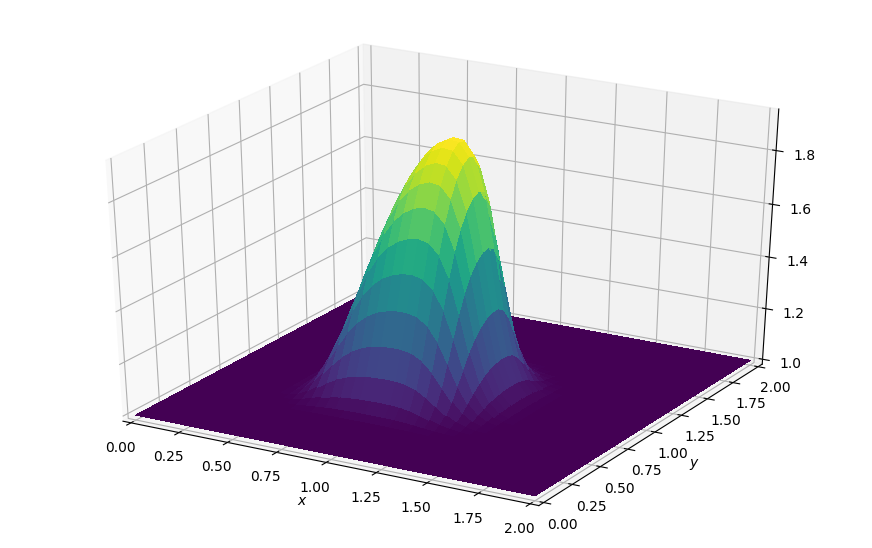

Operator `Kernel` run in 0.09 s


Batch: 2


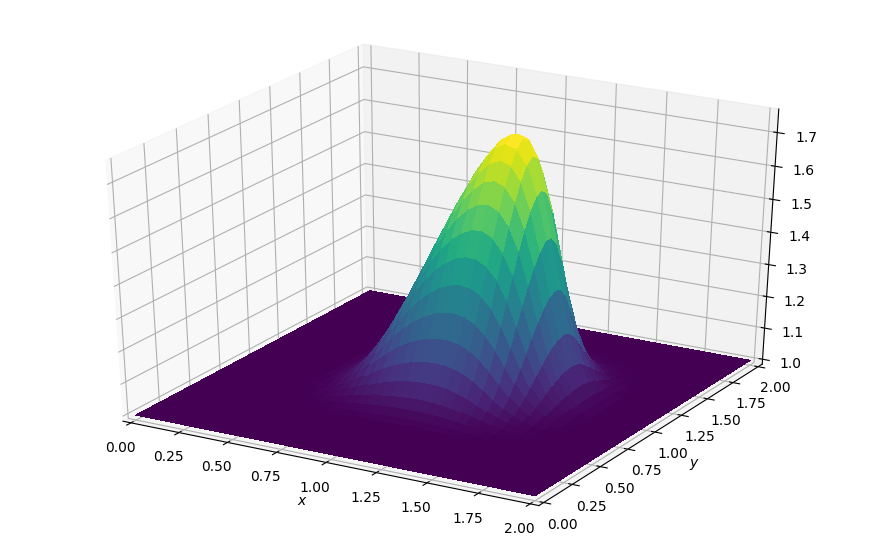

Operator `Kernel` run in 0.12 s


Batch: 3


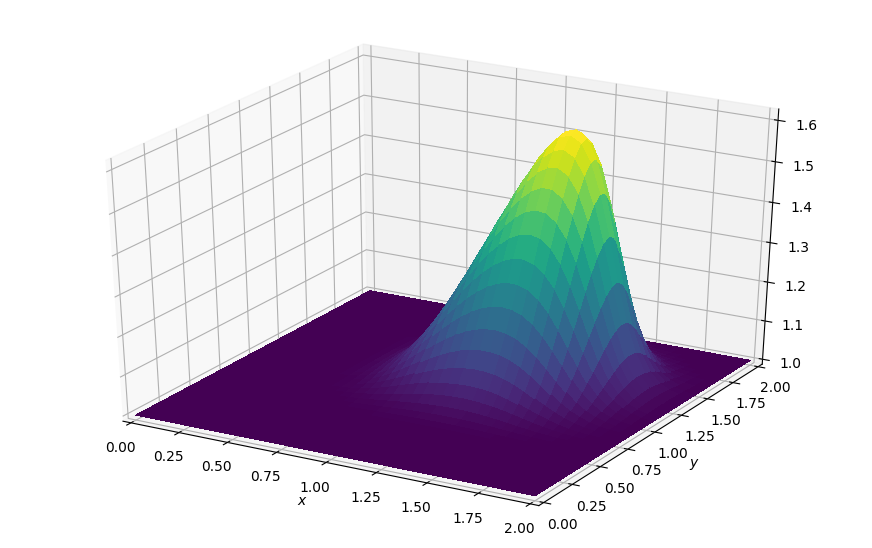

Operator `Kernel` run in 0.09 s


Batch: 4


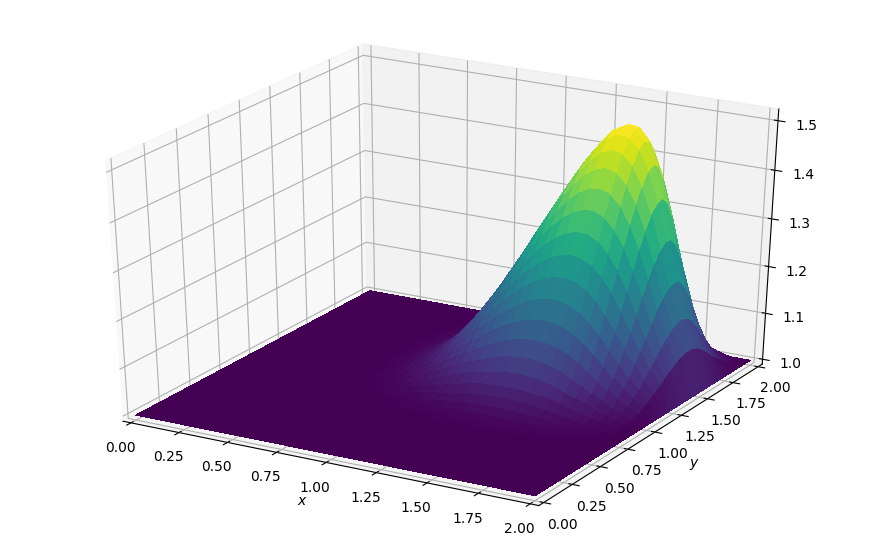

Operator `Kernel` run in 0.09 s


Batch: 5


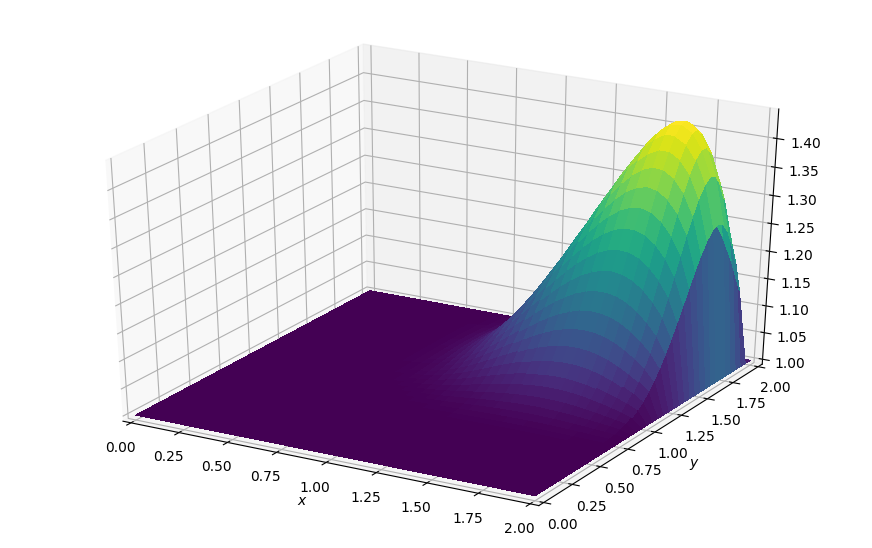

In [10]:
#NBVAL_IGNORE_OUTPUT
op = Operator([update_U] + bc_U)
# Execute the operator for a number of timesteps
for batch_no in range(batches):
    op(time=batch_size, dt=dt, a=nu)
    print ("Batch:",batch_no+1)
    plot_field(U[0].data[0])

In [13]:
from devito import norm
assert np.isclose(norm(u), norm(u[0]), rtol=1e-5, atol=0)

from devito import mmax, mmin
from matplotlib import cm

import matplotlib.pyplot as plt

xg = np.linspace(grid.origin[0].data,
                 grid.extent[0] + grid.origin[0].data,
                 grid.shape[0])


#make_test_video(u)

#umin = mmin(u)/4
#umax = mmax(u)/4
    #umin = -10.
    #umax = 10.
#nlevels = 10

#levels = list(np.linspace(umin, umax, nlevels))

#X, Z = np.mgrid[-abs_lay: Lx+abs_lay+1e-10: dx, -abs_lay: Lz+abs_lay+1e-10: dz]



def plot_save_field(field, filename, xmin=0., xmax=2., ymin=0., ymax=2., zmin=None, zmax=4,
               view=None, linewidth=0):
    """
    Utility plotting routine for 2D data.

    Parameters
    ----------
    field : array_like
        Field data to plot.
    xmax : int, optional
        Length of the x-axis.
    ymax : int, optional
        Length of the y-axis.
    view: int, optional
        View point to intialise.
    """
    if xmin > xmax or ymin > ymax:
        raise ValueError("Dimension min cannot be larger than dimension max.")
    if (zmin is not None and zmax is not None):
        if zmin > zmax:
            raise ValueError("Dimension min cannot be larger than dimension max.")
    elif(zmin is None and zmax is not None):
        if np.min(field) >= zmax:
            warning("zmax is less than field's minima. Figure deceptive.")
    elif(zmin is not None and zmax is None):
        if np.max(field) <= zmin:
            warning("zmin is larger than field's maxima. Figure deceptive.")
    x_coord = np.linspace(xmin, xmax, field.shape[0])
    y_coord = np.linspace(ymin, ymax, field.shape[1])
    fig = plt.figure(figsize=(14, 8), dpi=240)
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x_coord, y_coord, indexing='ij')
    ax.plot_surface(X, Y, field[:], cmap=cm.viridis, rstride=1, cstride=1,
                    linewidth=linewidth, antialiased=False)

    # Enforce axis measures and set view if given
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if zmin is None:
        zmin = np.min(field)
    if zmax is None:
        zmax = np.max(field)
    ax.set_zlim(zmin, zmax)

    if view is not None:
        ax.view_init(*view)

    # Label axis
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.savefig(filename)
    #plt.show()
    plt.close








for i in range (U.shape[0]):
    filename = 'im' + str("{:03d}".format(i)) + '.png'
    #fig = plt.figure(figsize=(16, 8))
    #ax1 = fig.add_subplot(111)
    plot_save_field(u.data[i, :, :],filename)
    print
    
    #ax1.plot(x, y, '-b')
    #cont = ax1.contourf(X,Z,u.data[i,:,:], levels, cmap=cm.seismic)
    #fig.colorbar(cont)
    #ax1.axis([0, Lx, 0, Lz])
    #ax1.set_xlabel('$x$')
    #ax1.set_ylabel('$z$')

    #plt.gca().invert_yaxis()
    #plt.savefig(filename)
    #plt.close()

#ffmpeg -framerate 30 -pattern_type glob -i '*.png'   -c:v libx264 -pix_fmt yuv420p out.mp4

IndexException: Rank mismatch.